In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import azureml.core
from azureml.core import Workspace, Model
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice



In [ ]:
# Load data
data = pd.read_csv("data.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop("Target", axis=1), data["Target"], test_size=0.2)


In [ ]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


In [ ]:
# Get the AzureML workspace
ws = Workspace.from_config()

# Register the model in the workspace
model = Model.register(model_path="model.pkl", 
                       model_name="logistic_regression_model", 
                       tags={"type": "classification"}, 
                       workspace=ws)


In [ ]:
# Create an inference configuration
inference_config = InferenceConfig(entry_script="score.py", environment=None)

# Deploy the model as a web service
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)
service = Model.deploy(workspace=ws, 
                       name="logistic_regression_service", 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=deployment_config)

# Wait for the deployment to complete
service.wait_for_deployment(True)


In [1]:
pwd

'/Users/tafadzwagoremusandu/Documents'

## THE Auto MPG dataset

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [47]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2023-03-09 00:08:49.679084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [25]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [26]:
df = raw_dataset.copy()

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [6]:
df.isna().sum()   # check unknown values

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [27]:
df = df.dropna()     #drop the few unknown rows

In [28]:
df['Origin'].value_counts()   # how many categories do we have for the Origin column

1    245
3     79
2     68
Name: Origin, dtype: int64

In [29]:
# The Origin column is categorical, we one-hot encode the values in the column with pd.get_dummies

df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [31]:
# Split the data into training and test sets

train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

In [37]:
df.corr()['MPG'].sort_values()

Weight         -0.832244
Displacement   -0.805127
Horsepower     -0.778427
Cylinders      -0.777618
USA            -0.565161
Europe          0.244313
Acceleration    0.423329
Japan           0.451454
Model Year      0.580541
MPG             1.000000
Name: MPG, dtype: float64

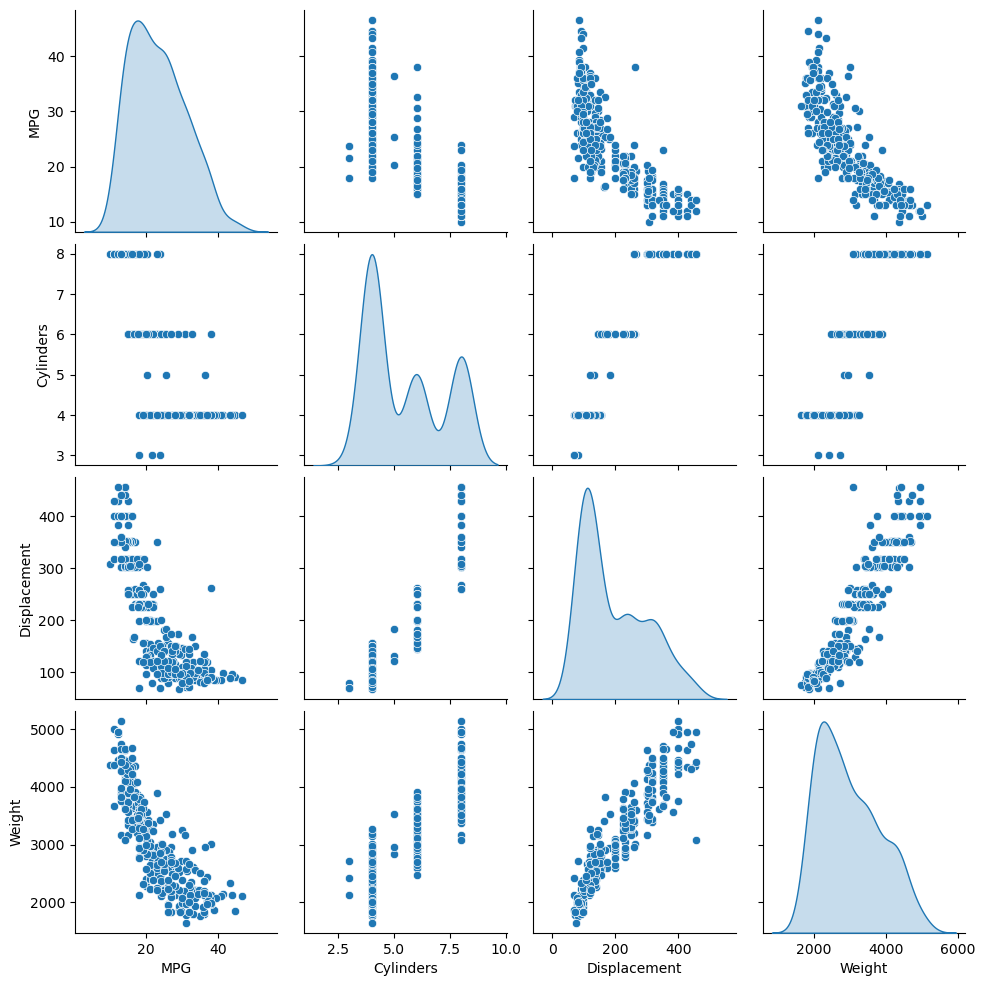

In [41]:
# Inspect the data, what is the joint distribution between the pairs of columns form the training data

sns.pairplot(train_df[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [42]:
df.describe().transpose()    # what is the range for each feature

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0


In [43]:
# Split the features from the labels
# Separate the target value - the "label" from the features, the label is that you will train the model to predict

train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [46]:
# Normalization

# we saw earlier how different the ranges of each feature are

train_df.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [ ]:
# it is good practise to normalise the features that use different scales and ranges

# this is because the features are multiplied by model weights. 
# So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs

# Although the model might converge without feature normalization, normalization makes training much more stable

# Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity.


### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:



In [48]:
normalizer = tf.keras.layers.Normalization(axis=-1)


Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [49]:
normalizer.adapt(np.array(train_features))

2023-03-09 00:13:51.518108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Calculate the mean and variance, and store them in the layer:

In [50]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [ ]:
# When the layer is called, it returns the input data, with each feature independently normalized:

In [51]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


### Linear regression with one variable

Begin with a single-variable linear regression to predict `'MPG'` from `'Horsepower'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.



First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [54]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [55]:
# Build the Keras Sequential model:

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [56]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [57]:
# Use Keras Model.fit to execute the training for 100 epochs:

%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3 s, sys: 292 ms, total: 3.29 s
Wall time: 3.16 s


In [68]:
# Visualize the model's training progress using the stats stored in the history object:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802572,4.190948,95
96,3.806442,4.194369,96
97,3.803236,4.199866,97
98,3.807430,4.179756,98
99,3.802842,4.199881,99


In [69]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

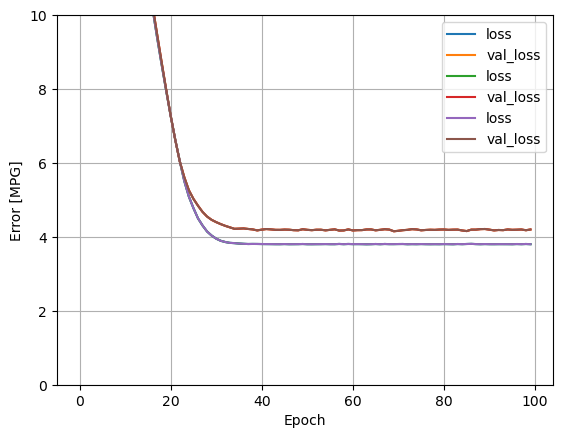

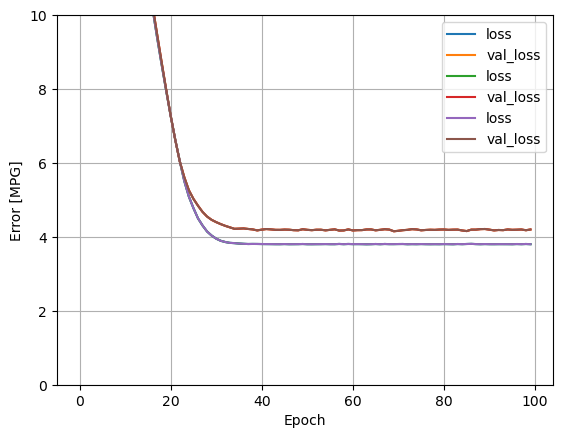

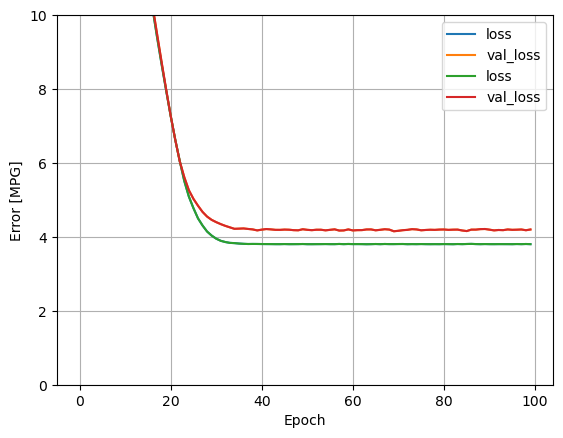

In [79]:
plot_loss(history)
plt.show()

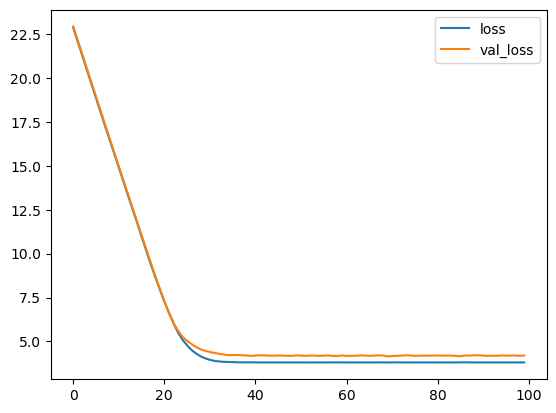

In [80]:
hist[['loss','val_loss']].plot()    # same way to plot the chart above , needs labelling on the axis
plt.show()

In [71]:
# Collect the results on the test set for later:

test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [ ]:
# Linear Regression with multiple inputs


You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [81]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [82]:
# When you call Model.predict on a batch of inputs, it produces units=1 outputs for each example:
# the model is yet untrained here

linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 70ms/step


array([[-1.438],
       [-0.756],
       [-0.783],
       [-0.93 ],
       [ 2.283],
       [-0.572],
       [ 2.373],
       [ 0.759],
       [-0.95 ],
       [ 2.112]], dtype=float32)

In [83]:
# Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [85]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2.6 s, sys: 182 ms, total: 2.79 s
Wall time: 2.53 s


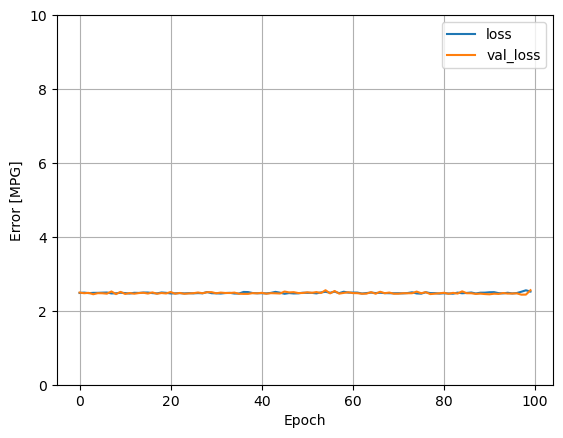

In [86]:
# Using all the inputs in this regression model achieves 
# a much lower training and validation error than the horsepower_model, which had one input:

plot_loss(history)
plt.show()

In [87]:
# Collect the results on the test set for later:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [88]:
# Regression with a Deep Neural network (DNN)


In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:
These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [90]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
# Regression using a DNN and. a single input

# Create a DNN model with only 'Horsepower' as input and horsepower_normalizer (defined earlier)
# as the normalization layer:


In [91]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [92]:
# This model has quite a few more trainable parameters than the linear models:

dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [93]:
# Train the model with Keras Model.fit:

%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


CPU times: user 3.28 s, sys: 227 ms, total: 3.51 s
Wall time: 3.11 s


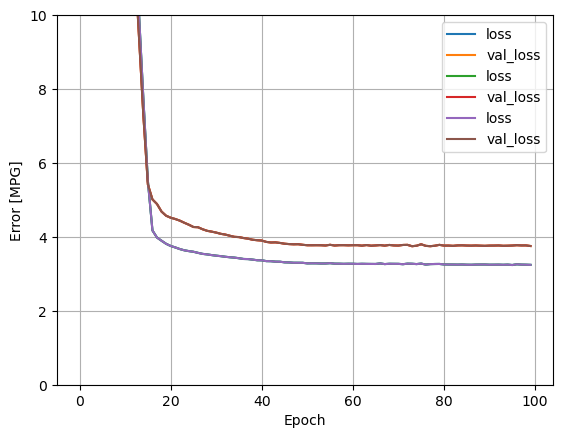

In [96]:
# This model does slightly better than the linear single-input horsepower_model:

plot_loss(history)
plt.show()

In [97]:
# If you plot the predictions as a function of 'Horsepower', 
# you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)


8/8 [==============================] - 0s 1ms/step


In [98]:
plot_horsepower(x, y)
plt.show()

NameError: name 'plot_horsepower' is not defined

In [99]:
# Collect the results on the test set for later

test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [ ]:
# Regression using a DNN and  multiple inputs

# Repeat the previous process using all the inputs. 
# The model's performance slightly improves on the validation dataset.

In [100]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [101]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.44 s, sys: 246 ms, total: 3.69 s
Wall time: 3.27 s


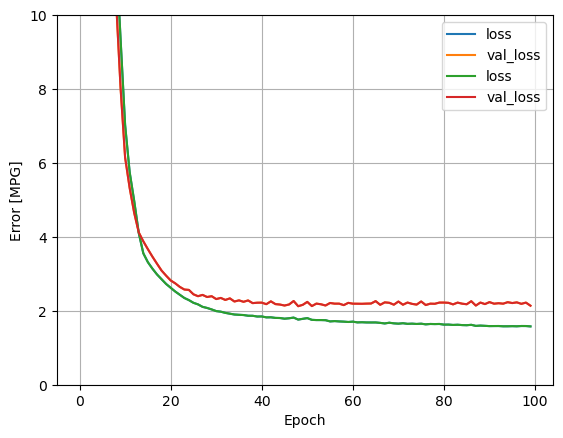

In [103]:
plot_loss(history)
plt.show()

In [104]:
# Collect the results on the test set:

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
# PERFORMANCE 

# Since all models have been trained, you can review their test set performance:


In [105]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649508
linear_model,2.608232
dnn_horsepower_model,2.892810
dnn_model,1.709906


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

3/3 [==============================] - 0s 2ms/step


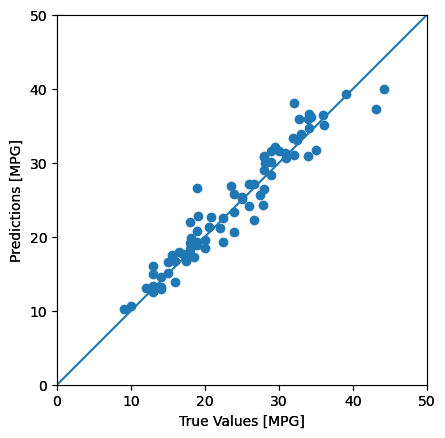

In [107]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

It appears that the model predicts reasonably well.

Now, check the error distribution:

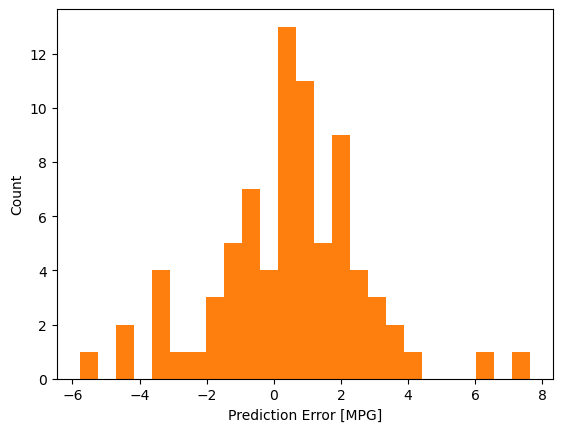

In [109]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')
plt.show()

In [110]:
# save the model for later use

dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.